# Convolutional Neural Networks
This notebook will guide you through the use of the `keras` package to train convolutional neural networks for handwritten digits classification. You are going to use the `mnist` dataset from LeCun et al. 1998.

## Loading the packages

In [1]:
import numpy as np
from matplotlib import pyplot as pl

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow import keras as keras
from sklearn import metrics as me

%matplotlib inline

2022-04-26 16:08:39.240529: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 16:08:39.240552: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Load the `mnist` dataset and normalize in the range [0, 1]

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

n_train, height, width = X_train.shape
n_test, _, _ = X_test.shape

X_train = np.expand_dims(X_train, axis=3).astype(np.float32)
X_test = np.expand_dims(X_test, axis=3).astype(np.float32)

X_train /= 255.0
X_test /= 255.0

n_classes = 10

print(n_train, 'train samples')
print(n_test, 'test samples')

# convert class vectors to binary class matrices
Y_train = keras.utils.to_categorical(y_train, n_classes)
Y_test = keras.utils.to_categorical(y_test, n_classes)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

60000 train samples
10000 test samples
(60000, 28, 28, 1) (60000,)
(10000, 28, 28, 1) (10000,)


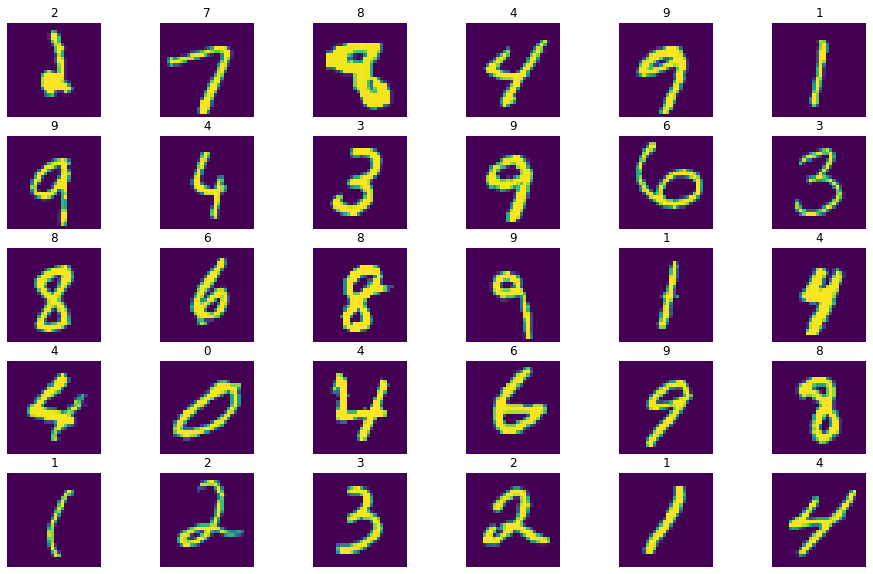

In [3]:
pl.figure(figsize=(16,10))
for i in range(30):
    pl.subplot(5,6,i+1)
    j = np.random.randint(0,X_train.shape[0])
    pl.imshow(X_train[j,:,:,0])
    pl.title(y_train[j])
    pl.axis('off')

### Make sure that the dimension ordering matches the backend (tensorflow)

In [4]:
print(keras.backend.image_data_format())

channels_last


### Create the CNN and show its architecture (Functional API)

In [5]:
l0 = keras.layers.Input(shape=(height, width, 1), name='l0')

l1 = keras.layers.Conv2D(9, (5, 5), padding='same', activation='relu', name='l1')(l0)
l1_mp = keras.layers.MaxPooling2D(pool_size=(2, 2), name='l1_mp')(l1)

l2 = keras.layers.Conv2D(9, (5, 5), padding='same', activation='relu', name='l2')(l1_mp)
l2_mp = keras.layers.MaxPooling2D(pool_size=(2, 2), name='l2_mp')(l2)

l3 = keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu', name='l3')(l2_mp)
l3_mp = keras.layers.MaxPooling2D(pool_size=(2, 2), name='l3_mp')(l3)

flat = keras.layers.Flatten(name='flat')(l3_mp)

l4 = keras.layers.Dense(25, activation='relu', name='l4')(flat)

l5 = keras.layers.Dense(n_classes, activation='softmax', name='l5')(l4)

model = keras.models.Model(inputs=l0, outputs=l5)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 l0 (InputLayer)             [(None, 28, 28, 1)]       0         
                                                                 
 l1 (Conv2D)                 (None, 28, 28, 9)         234       
                                                                 
 l1_mp (MaxPooling2D)        (None, 14, 14, 9)         0         
                                                                 
 l2 (Conv2D)                 (None, 14, 14, 9)         2034      
                                                                 
 l2_mp (MaxPooling2D)        (None, 7, 7, 9)           0         
                                                                 
 l3 (Conv2D)                 (None, 7, 7, 16)          1312      
                                                                 
 l3_mp (MaxPooling2D)        (None, 3, 3, 16)          0     

2022-04-26 16:09:08.230999: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-26 16:09:08.231043: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-26 16:09:08.231086: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hector-pc): /proc/driver/nvidia/version does not exist


### Define some constants and train de CNN

In [6]:
batch_size = 128
n_epoch = 10

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=['accuracy'])

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=n_epoch, verbose=1,
                    validation_data=(X_test, Y_test))

Epoch 1/10
469/469 [==============================] - 16s 33ms/step - loss: 2.1983 - accuracy: 0.2555 - val_loss: 1.7252 - val_accuracy: 0.5146
Epoch 2/10
469/469 [==============================] - 14s 30ms/step - loss: 0.7034 - accuracy: 0.7948 - val_loss: 0.3103 - val_accuracy: 0.9078
Epoch 3/10
469/469 [==============================] - 14s 30ms/step - loss: 0.2398 - accuracy: 0.9283 - val_loss: 0.1814 - val_accuracy: 0.9435
Epoch 4/10
469/469 [==============================] - 14s 30ms/step - loss: 0.1822 - accuracy: 0.9440 - val_loss: 0.1483 - val_accuracy: 0.9532
Epoch 5/10
469/469 [==============================] - 14s 30ms/step - loss: 0.1548 - accuracy: 0.9524 - val_loss: 0.1440 - val_accuracy: 0.9537
Epoch 6/10
469/469 [==============================] - 14s 30ms/step - loss: 0.1363 - accuracy: 0.9574 - val_loss: 0.1198 - val_accuracy: 0.9610
Epoch 7/10
469/469 [==============================] - 15s 31ms/step - loss: 0.1244 - accuracy: 0.9617 - val_loss: 0.1117 - val_accuracy:

### Show the performance of the model

Test score: 0.09922534972429276
Test accuracy: 0.9668999910354614


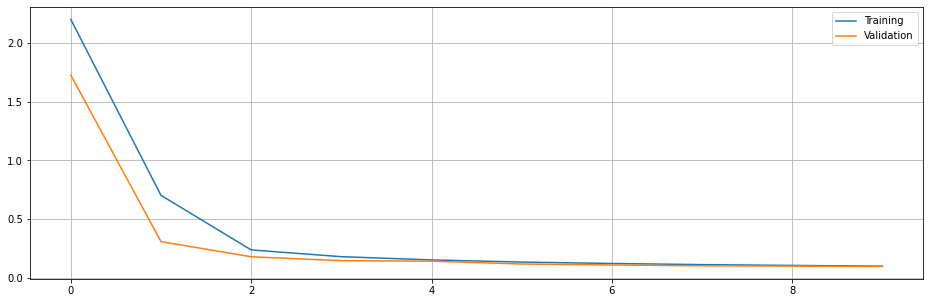

In [7]:
pl.figure(figsize=(16,5))
pl.plot(history.history['loss'], label='Training')
pl.plot(history.history['val_loss'], label='Validation')
pl.legend()
pl.grid()

score = model.evaluate(X_test, Y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

### Confusion matrix

In [8]:
pred_probas = model.predict_on_batch(X_test)
pred_classes = np.argmax(pred_probas, axis=-1)
me.confusion_matrix(y_test, pred_classes)

array([[ 969,    0,    1,    0,    0,    5,    1,    1,    2,    1],
       [   0, 1122,    2,    1,    0,    1,    2,    1,    6,    0],
       [   4,    4,  989,   10,    1,    3,    1,   12,    7,    1],
       [   1,    0,    1,  979,    0,   18,    0,    7,    1,    3],
       [   0,    0,    1,    1,  934,    0,    8,    4,    2,   32],
       [   3,    0,    0,    7,    0,  878,    1,    1,    2,    0],
       [   8,    3,    1,    0,    4,   13,  928,    0,    1,    0],
       [   1,    3,    5,    2,    0,    3,    0, 1002,    2,   10],
       [   9,    0,    2,   13,    4,   16,   11,    7,  901,   11],
       [   5,    6,    0,    7,    6,    8,    0,    9,    1,  967]])

### Show the activation of individual layers

In [9]:
class_target = 0                                    # select the class to be visualized

mask = Y_train[:,class_target] > 0.5
sample = np.random.choice(np.where(mask)[0],1)[0]   # choose a random sample of the selected class
layer_outputs = []
for l in range(1, len(model.layers)):
    get_layer_output = K.function([model.layers[0].input],
                                  [model.layers[l].output])
    layer_outputs.append(get_layer_output(X_train[sample:(sample+1)])[0][0])

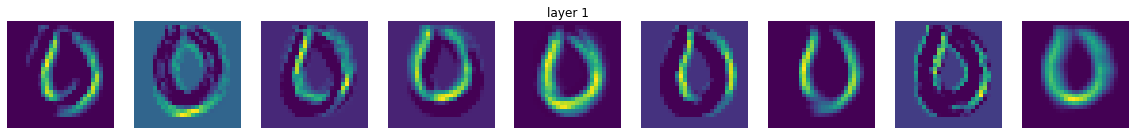

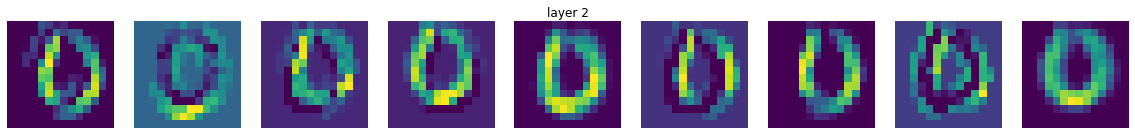

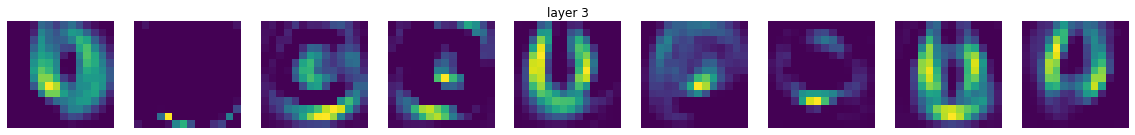

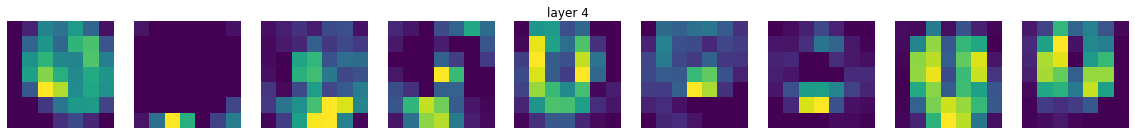

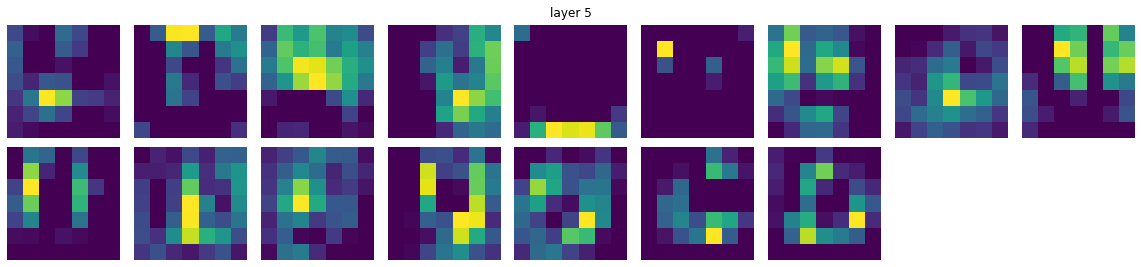

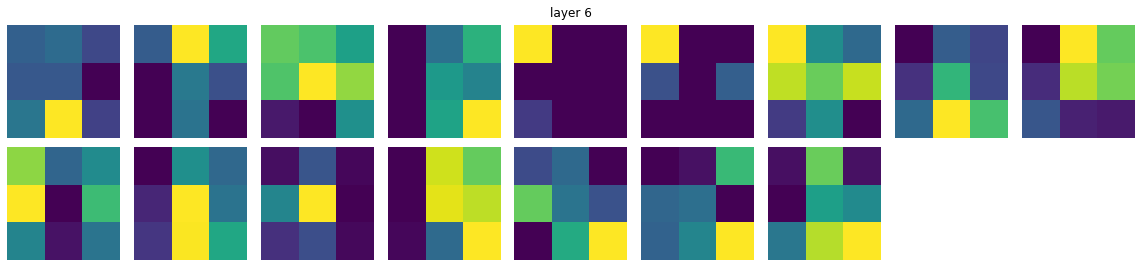

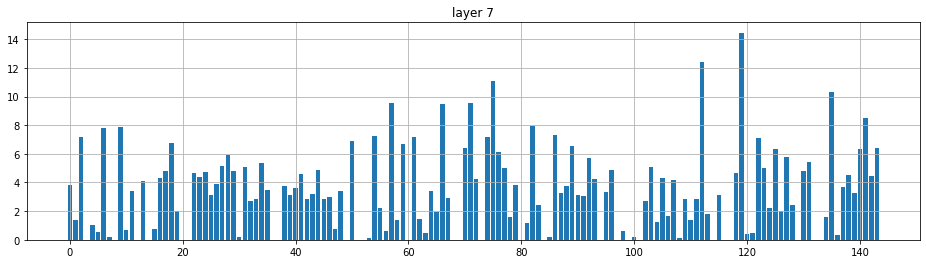

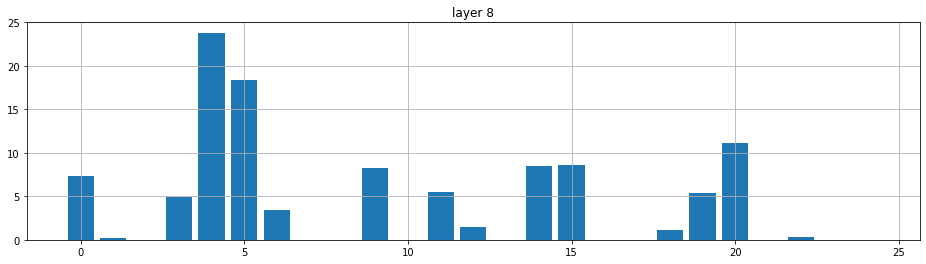

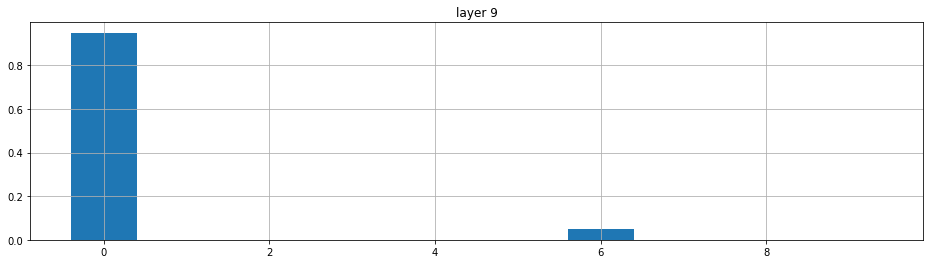

In [10]:
N_COLS = 9
for l,output in enumerate(layer_outputs):
    if len(output.shape) > 1:
        r = int(np.ceil(output.shape[2] / N_COLS))
        pl.figure(figsize=(16,r*(16/N_COLS)))
        for i in range(output.shape[2]):
            s = int(np.sqrt(output.shape[2]))
            pl.subplot(r,N_COLS,i+1)
            pl.imshow(output[:,:,i])
            pl.axis('off')
        pl.tight_layout()
        pl.suptitle(f'layer {l+1}', y=1.03)
    else:
        pl.figure(figsize=(16,4))
        pl.bar(np.arange(output.shape[0]), output)
        pl.grid()
        pl.title(f'layer {l+1}')